In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import string

import math
import json
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
products = pd.read_csv("./amazon_baby_subset.csv")

In [3]:
with open('./important_words.json') as data_file:    
    important_words = json.load(data_file)

In [4]:
with open('./module-4-assignment-train-idx.json') as data_file:    
    train = json.load(data_file)
    
with open('./module-4-assignment-validation-idx.json') as data_file:    
    validate = json.load(data_file)

In [5]:
products_train = products.loc[train]
products_validate = products.loc[validate]

In [6]:
products = products.fillna({"review": ""})
products_train = products_train.fillna({"review": ""})
products_validate = products_validate.fillna({"review": ""})

In [7]:
translator = str.maketrans('','', string.punctuation)
products["review"] = products["review"].astype(str)
products_train["review"] = products_train["review"].astype(str)
products_validate["review"] = products_validate["review"].astype(str)

def normalize_string(x):
    x = x.str.translate(translator)
    x = x.str.lower()
    
    return x

In [8]:
products["review_clean"] = normalize_string(products["review"])
products_train["review_clean"] = normalize_string(products_train["review"])
products_validate["review_clean"] = normalize_string(products_validate["review"])

In [9]:
vectorizer_word_subset = CountVectorizer(vocabulary = important_words)
train_matrix_word_subset = vectorizer_word_subset.fit_transform(products_train['review_clean'])
validate_matrix_word_subset = vectorizer_word_subset.transform(products_validate['review_clean'])

In [10]:
from scipy.sparse import hstack, coo_matrix

In [11]:
def get_numpy_data(dataframe, features, label):
    
    ones = coo_matrix(coo_matrix((dataframe.shape[0], 1), dtype=np.int8).toarray() + 1)
    feature_matrix = hstack([ones, dataframe])

    features = ["constant"] + features
    
    return (feature_matrix, features)

In [ ]:
feature_matrix_train, sentiment_train = get_numpy_data(train_matrix_word_subset, important_words, "sentiment")
feature_matrix_valid, sentiment_valid = get_numpy_data(validate_matrix_word_subset, important_words, "sentiment")

7)

Some problems with sparse data... back to numpy

In [10]:
for word in important_words:
    products_train[word] = products_train["review_clean"].apply(lambda x: x.split().count(word))

In [11]:
for word in important_words:
    products_validate[word] = products_validate["review_clean"].apply(lambda x: x.split().count(word))

In [12]:
def get_numpy_data(dataframe, features, label):
    
    dataframe["constant"] = 1
    features = ["constant"] + features
    
    feature_matrix = dataframe[features].as_matrix()
    label_array = dataframe[label].as_matrix()
    return (feature_matrix, label_array)

In [13]:
feature_matrix_train, sentiment_train = get_numpy_data(products_train, important_words, "sentiment")
feature_matrix_valid, sentiment_valid = get_numpy_data(products_validate, important_words, "sentiment")

In [14]:
feature_matrix_train

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       ..., 
       [1, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0]], dtype=int64)

In [15]:
def predict_probability(feature_matrix, coefficients):
    score = np.dot(feature_matrix,coefficients)
    
    predictions = 1/(1 + np.exp(-score))
    
    return predictions

In [16]:
predict_probability(feature_matrix_train, np.array([0] * 194))

array([ 0.5,  0.5,  0.5, ...,  0.5,  0.5,  0.5])

In [17]:
def feature_derivative(errors, feature):
    return np.dot(errors, feature)

In [18]:
def feature_derivative_L2penalty(errors, feature, coefficient, L2_pentalty):
    derivative = np.dot(errors, feature)
    derivative -= 2 * L2_pentalty * coefficient 
    
    return derivative

In [19]:
def compute_log_likelihood_L2penalty(feature_matrix, sentiment, coefficients, L2_pentalty):
    
    indicator = (sentiment == 1)
    scores = np.dot(feature_matrix, coefficients)
    
    lp = np.sum((indicator - 1) * scores - np.log(1 + np.exp(-scores)))
    lp -= L2_pentalty * np.sum(coefficients[1:] ** 2)
    
    return lp

In [20]:
def logistic_regression_withL2(feature_matrix, sentiment, initial_coeffs, 
                        step_size, max_iter, L2_pentalty) :
    
    coeffs = np.array(initial_coeffs)
    iteration = 0
    
    while iteration < max_iter:
        
        predictions = predict_probability(feature_matrix, coeffs)
        indicator = 1* (sentiment == 1)
        errors = indicator - predictions
        
        for i in range(len(coeffs)):
            
            if i == 0:
                derivative = feature_derivative(errors, feature_matrix[:,i])
            else :
                derivative = feature_derivative_L2penalty(errors, feature_matrix[:,i],
                                                         coeffs[i], L2_pentalty)
                    
            
            coeffs[i] += step_size * derivative
        
        iteration += 1
        
        if iteration <= 15 or (iteration <= 100 and iteration % 10 == 0) or (iteration <= 1000 and iteration % 100 == 0) \
        or (iteration <= 10000 and iteration % 1000 == 0) or iteration % 10000 == 0:
            lp = compute_log_likelihood_L2penalty(feature_matrix, sentiment, coeffs, L2_pentalty)
            print ('iteration %*d: log likelihood of observed labels = %.8f' % (int(np.ceil(np.log10(max_iter))), iteration, lp))
        
    return coeffs

In [21]:
fm = feature_matrix_train
st = sentiment_train
initial_coeffs = np.array([0.0] * feature_matrix_train.shape[1]) #np.zeros(194)
step_size = 5e-6
max_iter = 501
L2_pentalty = [4,10,1e2,1e3,1e5]

In [22]:
coefficients0 = logistic_regression_withL2(fm, st, initial_coeffs, step_size, max_iter, 0)
coefficients0

iteration   1: log likelihood of observed labels = -29140.90494121
iteration   2: log likelihood of observed labels = -28928.71848005
iteration   3: log likelihood of observed labels = -28725.05245713
iteration   4: log likelihood of observed labels = -28529.28381570
iteration   5: log likelihood of observed labels = -28340.89899298
iteration   6: log likelihood of observed labels = -28159.45740073
iteration   7: log likelihood of observed labels = -27984.56959298
iteration   8: log likelihood of observed labels = -27815.88382176
iteration   9: log likelihood of observed labels = -27653.07759417
iteration  10: log likelihood of observed labels = -27495.85227091
iteration  11: log likelihood of observed labels = -27343.92951289
iteration  12: log likelihood of observed labels = -27197.04884240
iteration  13: log likelihood of observed labels = -27054.96587260
iteration  14: log likelihood of observed labels = -26917.45094013
iteration  15: log likelihood of observed labels = -26784.2879

array([ -1.54248998e-01,   5.87381638e-02,   1.23174611e-02,
         8.94059639e-01,   1.15237861e+00,  -5.92440543e-03,
        -2.59252191e-01,   1.46509738e-02,   1.04113864e+00,
         5.05920469e-01,  -9.78467331e-02,   1.95219878e-01,
         4.18893562e-01,  -1.92675682e-01,  -2.19140933e-03,
        -1.61404879e-02,   1.30571337e-01,  -6.00728374e-02,
        -1.14049266e-01,  -2.74781372e-01,   2.11086343e-01,
         2.61129450e-01,   3.21675927e-03,   1.07957816e+00,
        -4.50488405e-02,  -6.71808929e-03,  -6.31475054e-02,
         1.99840593e-01,   1.92547420e-01,  -2.70345392e-01,
         1.11716265e-01,   3.75930156e-01,  -8.71179895e-02,
        -3.57970605e-01,   8.98095274e-01,   4.67661637e-01,
        -6.94152148e-03,  -1.06736455e-01,   5.91292951e-02,
        -8.56172046e-02,  -1.30103927e-01,   1.14227997e-01,
         3.39589145e-02,   4.04236061e-02,  -1.95905901e-01,
         2.02391532e-01,   6.64741674e-02,  -1.70396722e-01,
         3.67914081e-01,

In [23]:
coefficients1 = logistic_regression_withL2(fm, st, initial_coeffs, step_size, max_iter, 4)
coefficients2 = logistic_regression_withL2(fm, st, initial_coeffs, step_size, max_iter, 10)
coefficients3 = logistic_regression_withL2(fm, st, initial_coeffs, step_size, max_iter, 1e2)
coefficients4 = logistic_regression_withL2(fm, st, initial_coeffs, step_size, max_iter, 1e3)
coefficients5 = logistic_regression_withL2(fm, st, initial_coeffs, step_size, max_iter, 1e5)

iteration   1: log likelihood of observed labels = -29140.90941977
iteration   2: log likelihood of observed labels = -28928.74458068
iteration   3: log likelihood of observed labels = -28725.11591598
iteration   4: log likelihood of observed labels = -28529.39913058
iteration   5: log likelihood of observed labels = -28341.07954921
iteration   6: log likelihood of observed labels = -28159.71557184
iteration   7: log likelihood of observed labels = -27984.91682598
iteration   8: log likelihood of observed labels = -27816.33071233
iteration   9: log likelihood of observed labels = -27653.63395455
iteration  10: log likelihood of observed labels = -27496.52719189
iteration  11: log likelihood of observed labels = -27344.73142075
iteration  12: log likelihood of observed labels = -27197.98555108
iteration  13: log likelihood of observed labels = -27056.04463167
iteration  14: log likelihood of observed labels = -26918.67847871
iteration  15: log likelihood of observed labels = -26785.6705

iteration  14: log likelihood of observed labels = -29252.40713526
iteration  15: log likelihood of observed labels = -29252.39432999
iteration  20: log likelihood of observed labels = -29252.34620336
iteration  30: log likelihood of observed labels = -29252.29877908
iteration  40: log likelihood of observed labels = -29252.28104624
iteration  50: log likelihood of observed labels = -29252.27441559
iteration  60: log likelihood of observed labels = -29252.27193625
iteration  70: log likelihood of observed labels = -29252.27100917
iteration  80: log likelihood of observed labels = -29252.27066252
iteration  90: log likelihood of observed labels = -29252.27053290
iteration 100: log likelihood of observed labels = -29252.27048443
iteration 200: log likelihood of observed labels = -29252.27045548
iteration 300: log likelihood of observed labels = -29252.27045548
iteration 400: log likelihood of observed labels = -29252.27045548
iteration 500: log likelihood of observed labels = -29252.2704

In [27]:
features = ["constant"] + important_words

In [30]:
coefs = pd.DataFrame([coefficients0, coefficients1, coefficients2, coefficients3, coefficients4, coefficients5],
                    columns = features, index = [0,4,10,1e2,1e3,1e5])

In [31]:
coefs

,constant,baby,one,great,love,use,would,like,easy,little,...,seems,picture,completely,wish,buying,babies,won,tub,almost,either
0.0,-0.154249,0.058738,0.012317,0.894060,1.152379,-0.005924,-0.259252,0.014651,1.041139,0.505920,...,0.068137,-0.199165,-0.285193,0.163214,-0.119767,0.033183,0.004527,-0.159938,-0.053247,-0.218021
4.0,-0.153241,0.058774,0.012052,0.888996,1.144351,-0.005635,-0.258379,0.014425,1.033850,0.502970,...,0.067621,-0.197507,-0.282709,0.161755,-0.118763,0.032978,0.004479,-0.158615,-0.052728,-0.216085
10.0,-0.151747,0.058826,0.011660,0.881543,1.132545,-0.005210,-0.257096,0.014090,1.023128,0.498627,...,0.066862,-0.195063,-0.279049,0.159605,-0.117285,0.032677,0.004408,-0.156669,-0.051962,-0.213231
100.0,-0.131852,0.059429,0.006670,0.786974,0.984137,0.000081,-0.240945,0.009800,0.888234,0.443734,...,0.057177,-0.163933,-0.232435,0.132081,-0.098449,0.028897,0.003515,-0.132130,-0.042145,-0.176839
1000.0,-0.046441,0.053699,-0.009397,0.437837,0.485906,0.013353,-0.174689,-0.002739,0.434566,0.243872,...,0.024012,-0.062258,-0.083223,0.042614,-0.037609,0.015262,0.001027,-0.053297,-0.011215,-0.060602
100000.0,0.010470,0.001721,-0.001980,0.011395,0.011689,0.000352,-0.007986,-0.000846,0.010102,0.005963,...,0.000322,-0.001201,-0.001486,0.000461,-0.000783,0.000261,0.000017,-0.000945,-0.000166,-0.001042


In [32]:
five_pos_words = ['love', 'great', 'easy', 'loves', 'little']
five_neg_words = ['return', 'waste', 'back', 'get', 'disappointed']

In [33]:
words = five_pos_words + five_neg_words

In [34]:
coefs_10 = coefs[words]

In [35]:
coefs_10

,love,great,easy,loves,little,return,waste,back,get,disappointed
0.0,1.152379,0.894060,1.041139,1.079578,0.505920,-0.718148,-0.660899,-0.270345,-0.192676,-0.965155
4.0,1.144351,0.888996,1.033850,1.070813,0.502970,-0.711740,-0.655177,-0.268774,-0.191972,-0.956588
10.0,1.132545,0.881543,1.023128,1.057906,0.498627,-0.702302,-0.646755,-0.266464,-0.190936,-0.943967
100.0,0.984137,0.786974,0.888234,0.894179,0.443734,-0.582604,-0.540351,-0.237423,-0.177819,-0.783307
1000.0,0.485906,0.437837,0.434566,0.359548,0.243872,-0.209110,-0.206189,-0.134480,-0.121756,-0.271392
100000.0,0.011689,0.011395,0.010102,0.006587,0.005963,-0.003766,-0.003745,-0.004062,-0.004667,-0.004223


In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

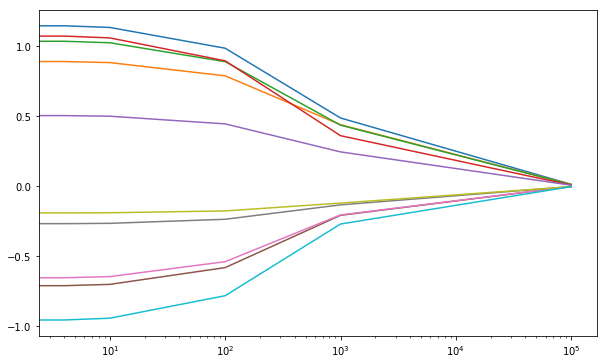

In [38]:
plt.plot( coefs_10.index, coefs_10)
plt.xscale('log')

In [39]:
def class_pred(feature_matrix, coefficients):
    score = np.dot(feature_matrix,coefficients)
    
    class_pred = 2*(score >= 0) - 1
    
    return class_pred

15)

In [44]:
def measure_accuracy(coeffictients):
    
    train_class = class_pred(feature_matrix_train, coeffictients)
    valid_class = class_pred(feature_matrix_valid, coeffictients)
    
    acc_train = round(np.sum(1 * (train_class == sentiment_train)) / len(train_class),2)
    acc_valid = round(np.sum(1 * (valid_class == sentiment_valid)) / len(valid_class),2)
    
    print(acc_train, acc_valid)

In [46]:
measure_accuracy(coefficients1)
measure_accuracy(coefficients2)
measure_accuracy(coefficients3)
measure_accuracy(coefficients4)
measure_accuracy(coefficients5)

0.8 0.8
0.8 0.8
0.8 0.79
0.79 0.79
0.7 0.69


In [47]:
for i in range(10):
    print(i)

0
1
2
3
4
5
6
7
8
9
